# Toy Problem 1: Static observations
## Problem description
The objective of this code is to generate simulated data which "looks like" data available for sea ice characterization. Here the considered toy problem aims to build the description of a 1D spatial field composed by different type, shapes and properties of ice. In this context, this script aims to generate 1D sea ice fields and returns ice thickness field (reference), sparse elevation field (IceSat-2 like data), average elevation field (CryoSat-2 like data), intensity field (SAR like data).


## 1D Block class

In order to easily manage properties sea ice regions we make the modeling assumption that a sea ice region is composed by a juxtaposition of blocks which share same characteristics but different properties. This will be useful to build simulated region sea ice composed by these elementary blocks (finite element type approach). A block of ice in this code is parametrized as follow:


<img src="block1d_class.png" alt="Block class" width="700">


The geometry of a block is defined by a length `l` and depth `hi_o`. To refine the prametrization of block geometry a block object is also define with a function `f_hit` describing the geometry of the interface between top ice and snown and `f_hib` describing the geometry of the surface of the bottom ice. For the snow depth in top of the ice, the property `f_hs` describe the snow repartition on top of the ice. By default, the block object is defined at the origin of the spatial domain with the property `x_o=0`. Other properties are assumed to be constant (for now) inside the block and are used for the freeboard model and to model the light intensity captured in a SAR image.

In [77]:
# Import required packages
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: rubiop
"""
import matplotlib.pyplot as plt
import numpy as np

from Block1DBase import BlockType, Block1D
from IceRegionBase import IceRegion
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm
from scipy.interpolate import interp1d

np.random.seed(25604)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

## Three types of sea ice

For this example we define 3 types: First-Year Ice, Multi-Year Ice and Water. 
Each type has its own characteristics that can be defined by statistical knwoledge.

<img src="values_biblio.png" alt="Biblio parameters" width="700">

Most difficult properties to specify are top and bottom ice interfaces. Here, each interface of each type is defined by means of Gaussian processes with different kernels.

In [78]:
#Create GP interface functions
m=20

kernel = 0.02 * RBF(length_scale=0.1)
gpr= GaussianProcessRegressor(kernel=kernel,copy_X_train=True,random_state=int(1e9))
x_ref=np.linspace(0,7,140) 
X = x_ref.reshape(-1, 1)
y_sample = gpr.sample_y(X, 4000,random_state=int(1e9))
y_mean, y_std = gpr.predict(X, return_std=True)
f_hit_myi=y_sample+2*y_std[0]
u, s, vh = np.linalg.svd(f_hit_myi)
vh=vh.T
u_hit_myi=u*s
u_hit_myi=u_hit_myi[:,:m]
vh=vh[:,:m]
m_hit_myi=np.mean(vh,axis=0)
cov_hit_myi=np.cov(vh.T)


kernel = 0.4 * RBF(length_scale=0.65)
gpr= GaussianProcessRegressor(kernel=kernel,copy_X_train=True,random_state=int(1e9))
x_ref=np.linspace(0,7,70) 
X = x_ref.reshape(-1, 1)
y_sample = gpr.sample_y(X, 4000,random_state=int(1e9))
y_mean, y_std = gpr.predict(X, return_std=True)
f_hib_myi=y_sample+2*y_std[0]

u, s, vh = np.linalg.svd(f_hib_myi)
vh=vh.T
u_hib_myi=u*s
u_hib_myi=u_hib_myi[:,:m]
vh=vh[:,:m]
m_hib_myi=np.mean(vh,axis=0)
cov_hib_myi=np.cov(vh.T)


kernel= 0.002 * RBF(length_scale=0.5)
gpr= GaussianProcessRegressor(kernel=kernel,copy_X_train=True,random_state=int(1e9))
x_ref=np.linspace(0,7,70) 
X = x_ref.reshape(-1, 1)
y_sample = gpr.sample_y(X, 4000,random_state=int(1e9))
y_mean, y_std = gpr.predict(X, return_std=True)
f_hit_fyi=y_sample+2*y_std[0]

u, s, vh = np.linalg.svd(f_hit_fyi)
vh=vh.T
u_hit_fyi=u*s
u_hit_fyi=u_hit_fyi[:,:m]
vh=vh[:,:m]
m_hit_fyi=np.mean(vh,axis=0)
cov_hit_fyi=np.cov(vh.T)


kernel = 0.02 * RBF(length_scale=1.7)
gpr= GaussianProcessRegressor(kernel=kernel,copy_X_train=True,random_state=int(1e9))
x_ref=np.linspace(0,7,70) 
X = x_ref.reshape(-1, 1)
y_sample = gpr.sample_y(X, 4000,random_state=int(1e9))
y_mean, y_std = gpr.predict(X, return_std=True)
f_hib_fyi=y_sample+2*y_std[0]

u, s, vh = np.linalg.svd(f_hib_fyi)
vh=vh.T
u_hib_fyi=u*s
u_hib_fyi=u_hib_fyi[:,:m]
vh=vh[:,:m]
m_hib_fyi=np.mean(vh,axis=0)
cov_hib_fyi=np.cov(vh.T)

def GP_fixed(mu,cov,u,seed):
   rng = np.random.RandomState(seed)
   coeff=rng.multivariate_normal(mu,cov)
   y_new=np.zeros(u[:,0].shape)
   for k in range(20):
      y_new=y_new+coeff[k]*u[:,k]
   return y_new

In [79]:
#Create block types

class FYIceBlock(BlockType):
   def __init__(self):
      super(FYIceBlock,self).__init__(np.random.rand(7,),'FYI')
      self.f_hit_fixed=GP_fixed(m_hit_fyi,cov_hit_fyi,u_hit_fyi,int(1e9*self.rand_hit))
      self.f_hib_fixed=GP_fixed(m_hib_fyi,cov_hib_fyi,u_hib_fyi,int(1e9*self.rand_hib))
   def f_hs(self,x):
      e_s=0.1*self.rand_hs
      f_hs = e_s*np.ones(x.shape)
      return f_hs.flatten()
   def f_hib(self,x):
      x_ref=np.linspace(0,7,70) 
      f_hib=interp1d(x_ref.flatten(), self.f_hib_fixed.flatten(),kind='linear',fill_value=0)
      return f_hib(x).flatten()
   def f_hit(self,x):
      x_ref=np.linspace(0,7,70) 
      f_hit=interp1d(x_ref.flatten(), self.f_hit_fixed.flatten(),kind='linear',fill_value=0)
      return f_hit(x).flatten()
   def l(self):
      return np.array([4+0.75*self.rand_l])
   def hi_o(self):
      return np.array([0.20+1*self.rand_hi])
   def rho_i(self):
      return 916.7-35.7+2*35.7*self.rand_id
   def rho_s(self):
      return 324-50+100*self.rand_sd

class MYIceBlock(BlockType):
   def __init__(self):
      super(MYIceBlock,self).__init__(np.random.rand(7,),'MYI')
      self.f_hit_fixed=GP_fixed(m_hit_myi,cov_hit_myi,u_hit_myi,int(1e9*self.rand_hit))
      self.f_hib_fixed=GP_fixed(m_hib_myi,cov_hib_myi,u_hib_myi,int(1e9*self.rand_hib))
   def f_hs(self,x):
      e_s=0.35-0.06+0.12*self.rand_hs
      f_hs = e_s*np.ones(x.shape)
      return f_hs.flatten()
   def f_hib(self,x):
      x_ref=np.linspace(0,7,70) 
      f_hib=interp1d(x_ref.flatten(), self.f_hib_fixed.flatten(),kind='linear',fill_value=0)
      return f_hib(x).flatten()
   def f_hit(self,x):
      x_ref=np.linspace(0,7,140) 
      f_hit=interp1d(x_ref.flatten(), self.f_hit_fixed.flatten(),kind='linear',fill_value=0)
      return f_hit(x).flatten()
   def l(self):
      return np.array([3+0.75*self.rand_l])
   def hi_o(self):
      return np.array([1.5+3*self.rand_hi])
   def rho_i(self):
      return 882-23+46*self.rand_id
   def rho_s(self):
      return 320-20+40*self.rand_sd

class WaterBlock(BlockType):
   def __init__(self):
      super(WaterBlock,self).__init__(np.random.rand(7,),'Water')
   def f_hs(self,x):
      f_hs = np.zeros(x.shape)
      return f_hs.flatten()
   def f_hib(self,x):
      f_hib = np.zeros(x.shape)
      return f_hib.flatten()
   def f_hit(self,x):
      f_hit = np.zeros(x.shape)
      return f_hit.flatten()
   def l(self):
      return np.array([2.5+1*self.rand_l])
   def hi_o(self):
      return np.array([0])
   def rho_i(self):
      return 1024
   def rho_s(self):
      return 324


Three classes have 

- Gaussian Process to model ice interfaces
- Constant snow depth
- Rougher, thicker MYI

## Example of FYI and MYI blocks:

In [80]:
block_fyi=Block1D(FYIceBlock())
block_myi=Block1D(MYIceBlock())

block_myi.x_o=block_fyi.l #translate 2nd block of the lenght of the first one

All properties are generated randomly at the object creation!

### Visualization

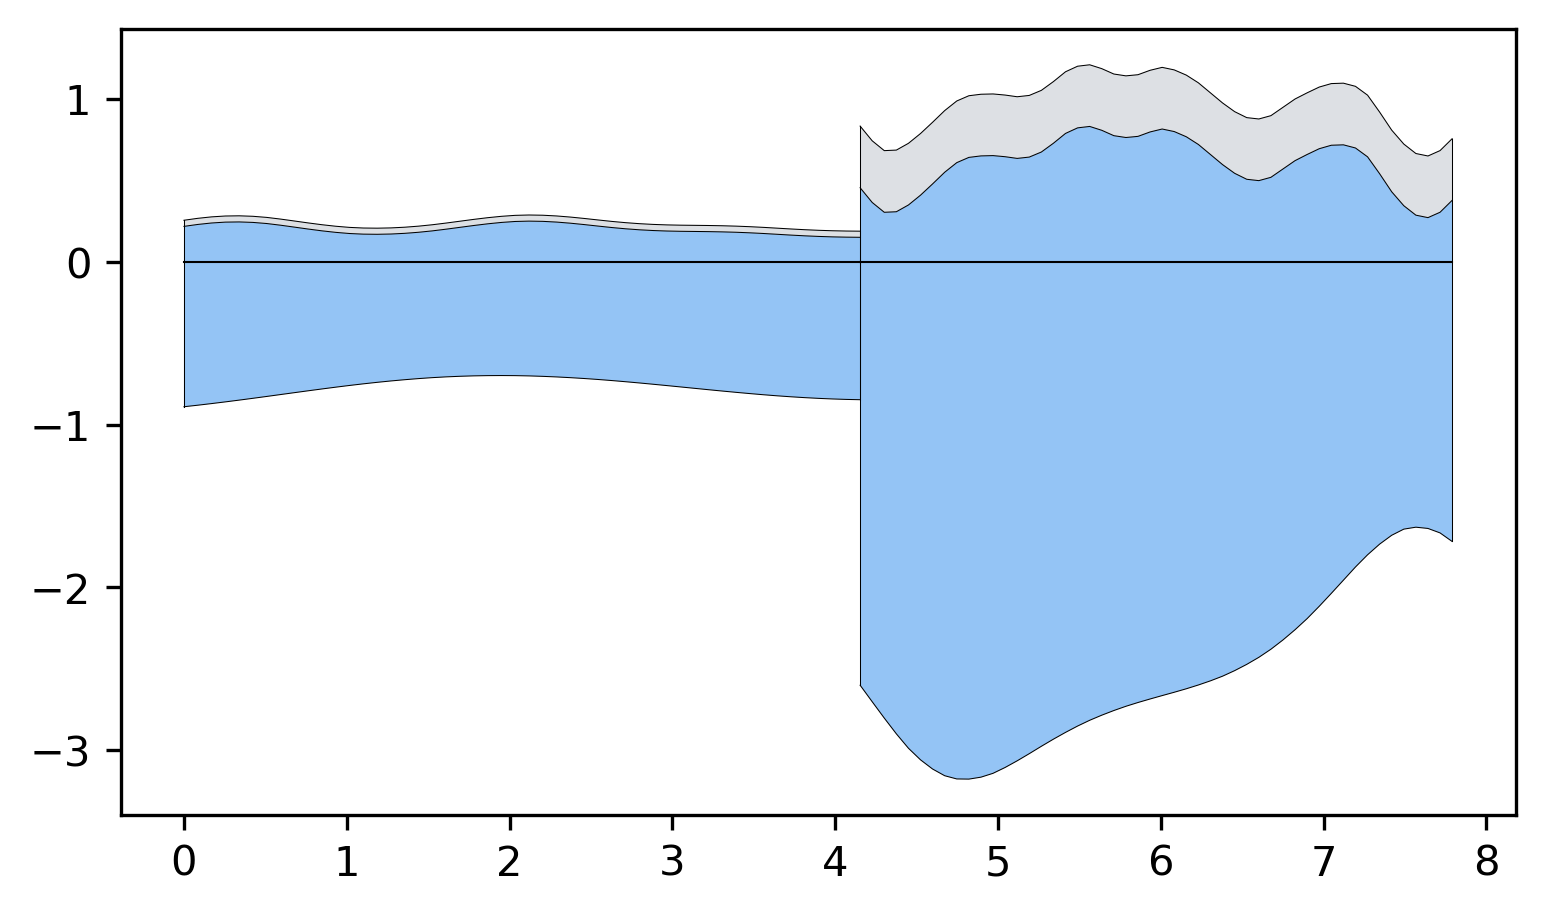

FYI freeboard (mean): 0.06618067489969359 MYI freeboard (mean): 0.3538139468476553


In [81]:
#Plot blocks
x=np.concatenate((np.linspace(0,block_fyi.l,50),np.linspace(block_fyi.l,block_fyi.l+block_myi.l,50)))
x=np.unique(x).flatten()

fig, ax = plt.subplots()
block_fyi.plot(x,ax)
block_myi.plot(x,ax)
ax.set_aspect('equal', 'box')
#plt.savefig('test.png', dpi=1000)
plt.show()
print('FYI freeboard (mean):',block_fyi.freeboard(x)[0], 'MYI freeboard (mean):',block_myi.freeboard(x)[-1] )

Freeboard is for now calculated with average ice and snow interfaces, need to improve to include ice block inclination?

 https://engaging-data.com/iceberger-remixed/?d

## Ice region with MYI, FYI and Water

A class have been created to automatically build simulated sea ice region with the three block ice type and random properties:

In [51]:
Nb=6
ratio_fyi=0.25
ratio_myi=0.75

ice_region1=IceRegion(Nb,FYIceBlock(),MYIceBlock(),WaterBlock(),ratio_fyi,ratio_myi)

### Visualization

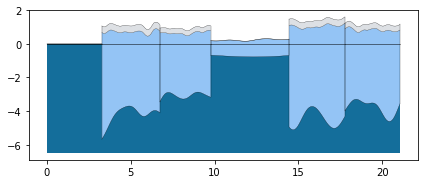

In [52]:
#Plot ice region

x_ir1=np.array([0])
for k,b in enumerate(ice_region1.block_list):
    if b.hi_o==0:
        x_ir1=np.concatenate((x_ir1.flatten(),np.linspace(b.x_o,b.x_o+b.l,2).flatten()))
    else:
        x_ir1=np.concatenate((x_ir1.flatten(),np.linspace(b.x_o,b.x_o+b.l,40).flatten()))

x_ir1=np.unique(x_ir1)
fig, ax = plt.subplots()
ice_region1.plot_region(x_ir1,ax)
ax.set_aspect('equal', 'box')
plt.tight_layout()
plt.show()

Once the ice region object is created we have access to global quantities (ice thickness, elevation etc.)

### Global outputs

Example with ice height above sea level:

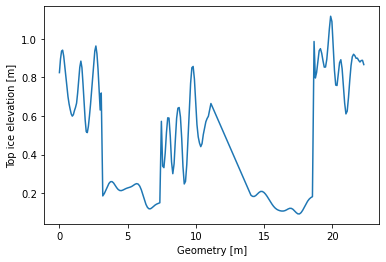

In [8]:
plt.figure()
plt.plot(x_ir1,ice_region1.top_ice_elevation(x_ir1))
plt.xlabel('Geometry [m]')
plt.ylabel('Top ice elevation [m]')
plt.show()

### Global inputs 

Enforce snow accumulation on a global level. Snow accumulation function is a Gaussian weighted by a function that increase snow accumulation at lowest location.

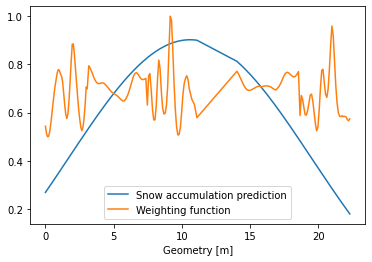

In [9]:
#Global snow accumulation model

elev_glob=ice_region1.elevation(x_ir1)

num=30 #Number of moving averages
b=np.ones(int(num))/num

mov_mean=np.convolve(ice_region1.top_ice_roughness(x_ir1), b, mode='same')#moving average

k_r=1

rough=ice_region1.top_ice_roughness(x_ir1)-mov_mean

rough=rough-np.min(rough)
rough=rough/np.max(rough)
rough=k_r/(rough+k_r)

f_rough=interp1d(x_ir1, rough,kind='linear',fill_value=0)

def snow_accumulation(x):
    gauss=-0.1+8*norm.pdf(x,loc=np.mean(x_ir1), scale=(x_ir1[-1]-x_ir1[0])/2.5)
    output=3.5*gauss*f_rough(x)
    return output.flatten()

def snow_accumulation2(x):
    gauss=-0.1+8*norm.pdf(x,loc=np.mean(x_ir1), scale=(x_ir1[-1]-x_ir1[0])/2.5)
    return gauss.flatten()

plt.figure()
plt.plot(x_ir1,3.5*snow_accumulation2(x_ir1))
plt.plot(x_ir1,f_rough(x_ir1))
plt.xlabel('Geometry [m]')
plt.legend(['Snow accumulation prediction','Weighting function'])
plt.show()

#### Result:

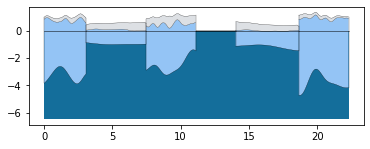

In [10]:
# Plot updated ice region
ice_region1.set_snow_depth(snow_accumulation)
fig, ax = plt.subplots()
ice_region1.plot_region(x_ir1,ax)
ax.set_aspect('equal', 'box')
plt.show()

Comparison between local and global snow accumulation models: 

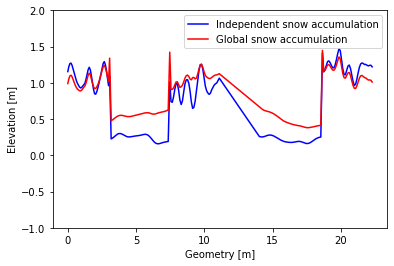

In [11]:
plt.figure()
plt.plot(x_ir1,elev_glob,'-b')
plt.plot(x_ir1,ice_region1.elevation(x_ir1),'r')
plt.ylim(-1,2)
plt.xlabel('Geometry [m]')
plt.ylabel('Elevation [m]')
plt.legend(['Independent snow accumulation','Global snow accumulation'])
plt.show()

## Data generation

Create larger scale see ice region:

In [12]:
ice_region2=IceRegion(1000,FYIceBlock(),MYIceBlock(),WaterBlock(),0.4,0.4)

### Reference elevation

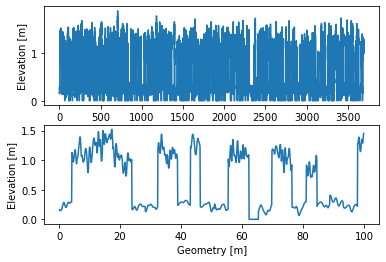

In [13]:
x_ir2=np.arange(ice_region2.x_b,ice_region2.x_e,0.1)
data_ref=ice_region2.elevation(x_ir2)

fig,ax=plt.subplots(2,1)
ax[0].plot(x_ir2,data_ref)
ax[0].set(xlabel='Geometry [m]', ylabel='Elevation [m]')
ax[1].plot(x_ir2[1:1000],data_ref[1:1000])
ax[1].set(xlabel='Geometry [m]', ylabel='Elevation [m]')
plt.show()

### IceSat-2 like data

In [14]:
def generate_ice_sat2(IceRegion,x_meas,noise = lambda x : x):
    ice_meas=noise(IceRegion.elevation(x_meas))
    return ice_meas

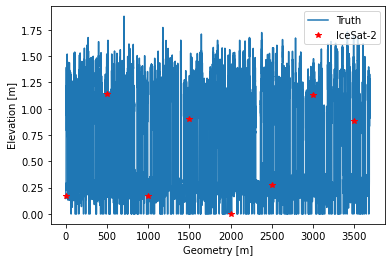

In [15]:
x_is2 = np.arange(ice_region2.x_b,ice_region2.x_e,500) #Choose 500 spaced locations

data_is2 = generate_ice_sat2(ice_region2,x_is2)

fig,ax=plt.subplots()
ax.plot(x_ir2,data_ref)
ax.plot(x_is2,data_is2,'r*')
ax.legend(['Truth', 'IceSat-2'])
plt.xlabel('Geometry [m]')
plt.ylabel('Elevation [m]')
plt.show()

### CryoSat-2 like data

Takes top ice elevation and return the average in a given centered area

In [16]:
def generate_cryo_sat2(IceRegion,x_meas,kern_const,noise = lambda x : x):
    cryo_meas=np.zeros(x_meas.shape)
    for k in range(len(x_meas)):
        int_space=np.linspace(x_meas[k]-kern_const/2,x_meas[k]+kern_const/2,500)
        cryo_meas[k]=np.mean(IceRegion.top_ice_elevation(int_space))
        cryo_meas=noise(cryo_meas)
    return cryo_meas

#### Example:

In [17]:
x_gs2=np.arange(ice_region2.x_b,ice_region2.x_e,500) #Choose 500m spaced location
C=500 #Use 500 m footprint average
data_gs2=generate_cryo_sat2(ice_region2,x_gs2,C)

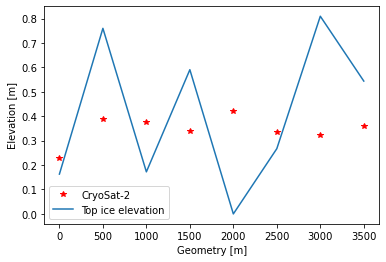

In [18]:
plt.figure()
plt.plot(x_gs2,data_gs2,'r*')
plt.plot(x_gs2,ice_region2.top_ice_elevation(x_gs2))
plt.legend(['CryoSat-2','Top ice elevation'])
plt.xlabel('Geometry [m]')
plt.ylabel('Elevation [m]')
plt.show()

### SAR like data

Here we use the intensity method (define with statistical or physical models) of blocks and region to generate data.

In [19]:
def generate_sar(IceRegion,reso,noise = lambda x : x):
    x=np.arange(IceRegion.x_b,IceRegion.x_e,reso)
    hh=np.zeros(x.shape)
    hv=np.zeros(x.shape)
    for k in range(len(x)):
        int_space=np.linspace(x[k]-reso/2,x[k]+reso/2,200)
        hh[k]=np.mean(IceRegion.intensity(int_space))
        hv[k]=np.mean(IceRegion.intensity(int_space))
    return (hh,hv)

In [20]:
reso=25
x_sar=np.arange(ice_region2.x_b,ice_region2.x_e,reso)
(hh,hv)=generate_sar(ice_region2,reso)

#### Example

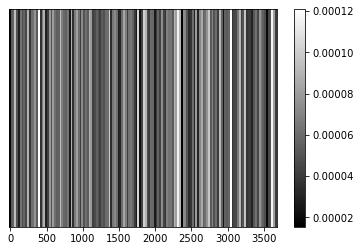

In [21]:
y, x = np.meshgrid(np.array([0,1]),x_sar)
z=np.zeros((x.shape))
z[:,0]=hh
z[:,1]=hh
fig,ax=plt.subplots()
plt.pcolor(x,y,z,cmap='gray')
ax=plt.gca()
plt.tick_params(left = False)
ax.axes.yaxis.set_ticklabels([])
plt.ylim(0,1)
plt.colorbar()
plt.show()

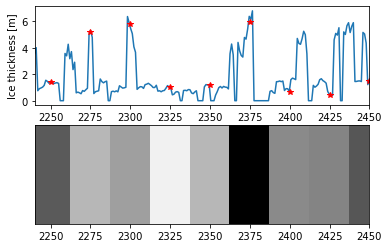

In [22]:
#Plot smaller part
x_test=np.linspace(2240,2450,210)

fig,ax=plt.subplots(2,1)
ax[0].plot(x_test,ice_region2.ice_thickness(x_test))
ax[0].plot(x_sar,ice_region2.ice_thickness(x_sar),'r*')
ax[0].set_xlim([x_test[0], x_test[-1]])
ax[0].set(ylabel='Ice thickness [m]')
ax[1].pcolor(x,y,z,cmap='gray')
ax[1].set_xlim([x_test[0], x_test[-1]])
ax[1].set_yticks([])
plt.show()

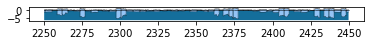

In [23]:
x_w=x_ir2[22500:24500]

fig, ax = plt.subplots()
ice_region2.plot_region(x_w,ax)
ax.set_aspect('equal')
plt.show()

## Future improvements:
- 1D case:
    - Generate block types as GP
    - Improve physics of statistical models
- 2D case:
    - Stack 1D cases with constant row width
    - Use a regular squared grid + block type interface functions + quadtree segmentation https://github.com/domoench/Quadtree